##### Imports and loading the dataset

In [1]:
import opendatasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
# import scikit-learn as sklearn
# import regex as re
from dateutil.relativedelta import relativedelta
# opendatasets.download('https://www.kaggle.com/datasets/vijayuv/onlineretail')

In [2]:
data = pd.read_csv('onlineretail/OnlineRetail.csv', encoding='ISO-8859-1')
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


##### Data pre-processing --> Data Cleaning

In [3]:
price_threshold = 0  # Example: remove rows with price <= 0
quantity_threshold = 0  # Example: remove rows with quantity <= 0

# Keep only rows where BOTH conditions are met
data = data[(data['UnitPrice'] > price_threshold) & (data['Quantity'] > quantity_threshold)]
# data.reset_index(inplace=True)
# data.iloc[:,:]
data.reset_index(drop=True, inplace=True)
data = data[data['InvoiceNo'] != 'A563185']
data['InvoiceNo'] = data['InvoiceNo'].astype(int) # made the InvoiceNo as int

data['TotalPrice'] = data['UnitPrice'] * data['Quantity']
data['TotalPrice'] = data['TotalPrice'].astype(float)


data['Date'] = pd.to_datetime(data['InvoiceDate'].apply(lambda x: str(x).split(' ')[0].replace('/','-')))
data['Time'] = data['InvoiceDate'].apply(lambda x: str(x).split(' ')[1])
data['Hour'] = data['Time'].apply(lambda x: int(x.split(':')[0]))
data['DayOfWeek'] = data['Date'].dt.day_name()
data['Month'] = data['Date'].dt.month_name()
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date,Time,Hour,DayOfWeek,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,2010-12-01,8:26,8,Wednesday,December
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,2010-12-01,8:26,8,Wednesday,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530099,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20,2011-12-09,12:50,12,Friday,December
530100,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60,2011-12-09,12:50,12,Friday,December
530101,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09,12:50,12,Friday,December
530102,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09,12:50,12,Friday,December


### 1. Data Overview and Quality Assessment

##### What is the time period covered in the dataset?

In [5]:
Start_Date = pd.to_datetime(data['InvoiceDate'][0].split(' ')[0].replace('/','-'))
End_Date = pd.to_datetime(data['InvoiceDate'].iloc[-1].split(' ')[0].replace('/','-'))
# Time_Period = pd.date_range(Start_Date, End_Date, freq='ME')
# Time_Period
Time_Period = relativedelta(End_Date, Start_Date)
Time_Period_Text = f"{Time_Period.years} years, {Time_Period.months} months, {Time_Period.days} days"
Time_Period_Text

'1 years, 0 months, 8 days'

##### How many unique transactions, customers, and products are there?

In [6]:
unique_customers = data['CustomerID'].nunique()
unique_transactions = data['InvoiceNo'].nunique()
unique_products = data['Description'].nunique()
unique_country = data['Country'].unique()
unique_country

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Bahrain', 'Israel', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

##### Are there any data quality issues (missing values, duplicates, outliers)?"

In [7]:

# duplicates--> 
duplicates = data.duplicated().sum()
duplicates

# outliers-->
# Outliers can be detected using the IQR method
Q1 = data['UnitPrice'].quantile(0.25)
Q3 = data['UnitPrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data[(data['UnitPrice'] < lower_bound) | (data['UnitPrice'] > upper_bound)]
outliers_count = outliers.shape[0]
outliers_count

37998

##### Are there any unusual patterns in the data (negative quantities, zero prices)?

In [8]:
# negative_quantities = len(data) - len(data[data['Quantity'] > 0])
# data['Quantity'] = data['Quantity'].replace(0, np.nan)
# zero_prices = data[data['UnitPrice'] <= 0]
# len(zero_prices)


In [9]:
541909-530104

11805

### 2. Customer Behavior Analysis

##### How are sales distributed across different countries?

In [10]:
a = data.groupby(['Country'])['InvoiceNo'].sum()
a

Country
Australia                  657415628
Austria                    223822318
Bahrain                      9936937
Belgium                   1138462862
Brazil                      17606432
Canada                      84252636
Channel Islands            417972473
Cyprus                     341888568
Czech Republic              13876340
Denmark                    213742248
EIRE                      4429345799
European Community          33434869
Finland                    382635802
France                    4714753052
Germany                   5061018356
Greece                      80713029
Hong Kong                  157626844
Iceland                    101296926
Israel                     165712058
Italy                      425518649
Japan                      176939004
Lebanon                     24402420
Lithuania                   18798630
Malta                       62931641
Netherlands               1318829653
Norway                     603201625
Poland                     184

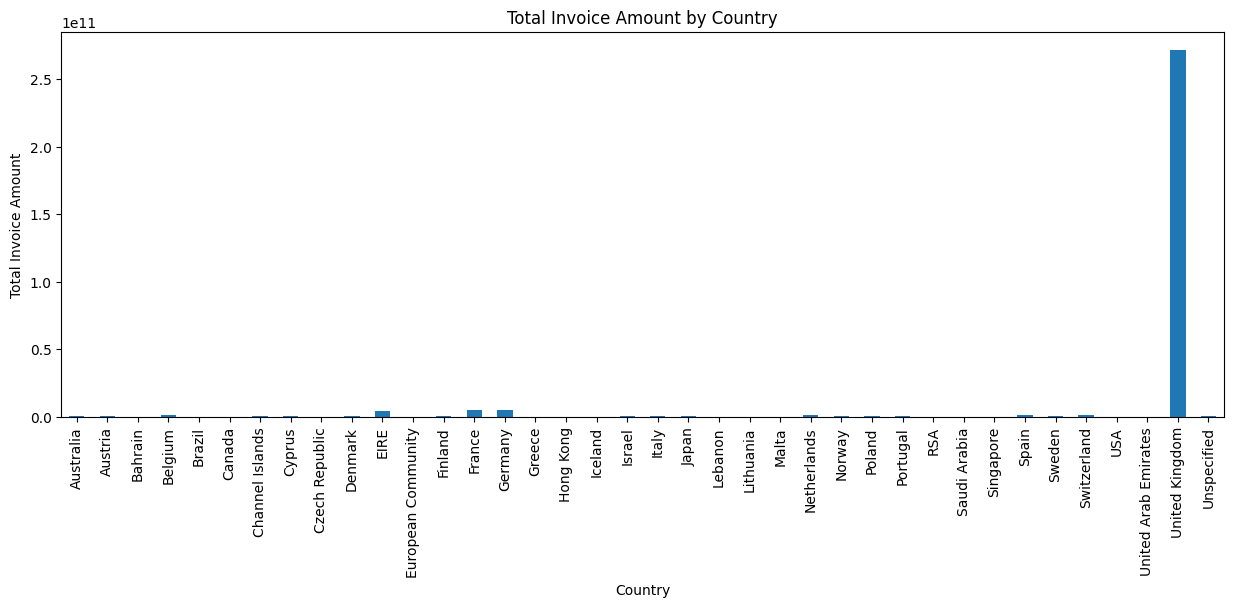

In [11]:
a.plot(kind='bar', figsize=(15, 5))
plt.title('Total Invoice Amount by Country')
plt.xlabel('Country')
plt.ylabel('Total Invoice Amount')
plt.xticks(rotation=90)
plt.show()

In [12]:
type(data['InvoiceNo'][0])

numpy.int64

##### What is the distribution of order sizes (number of items per transaction)?

In [13]:
items_per_transaction = data.groupby('InvoiceNo')['Quantity'].sum()

Text(0, 0.5, 'Frequency (Number of Transactions)')

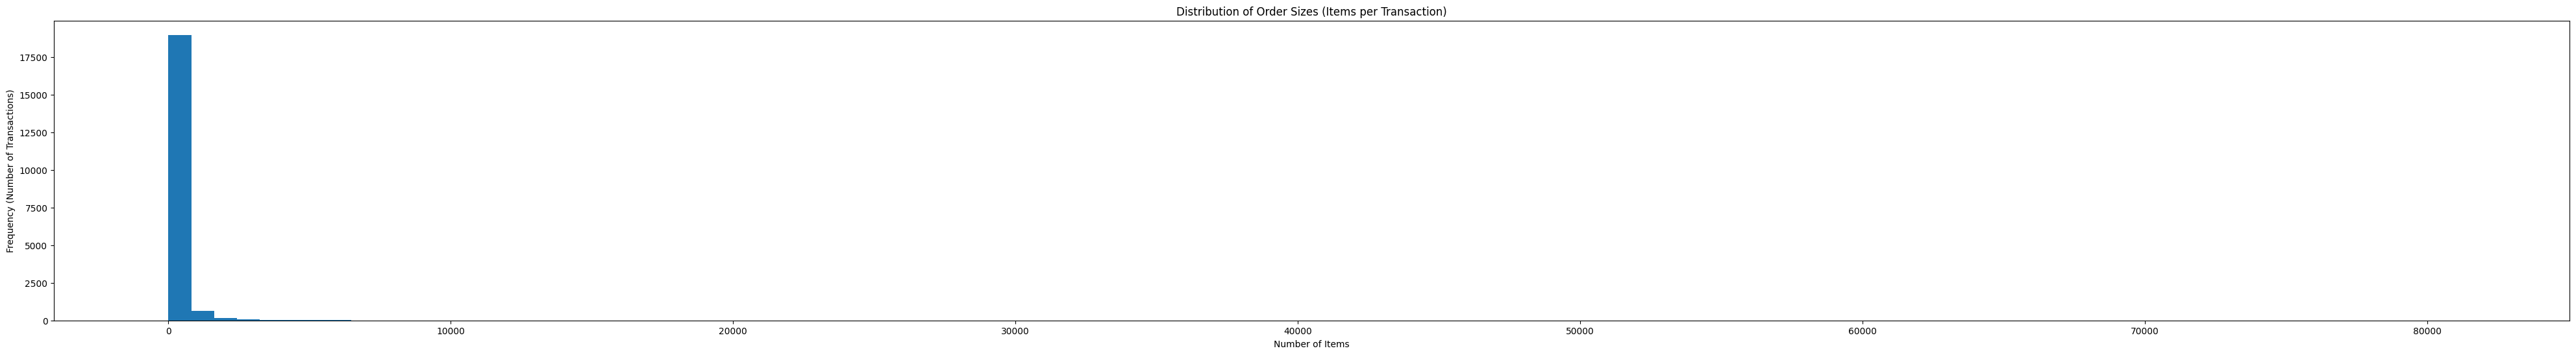

In [14]:
data.groupby('InvoiceNo')['Quantity'].sum().plot(kind='hist', bins=100, figsize=(50, 6))
plt.title('Distribution of Order Sizes (Items per Transaction)')
plt.xlabel('Number of Items')
plt.ylabel('Frequency (Number of Transactions)')

##### What is the typical basket value (total transaction amount)?

Text(0.5, 1.0, 'Distribution of Order Values (Total Price per Transaction)')

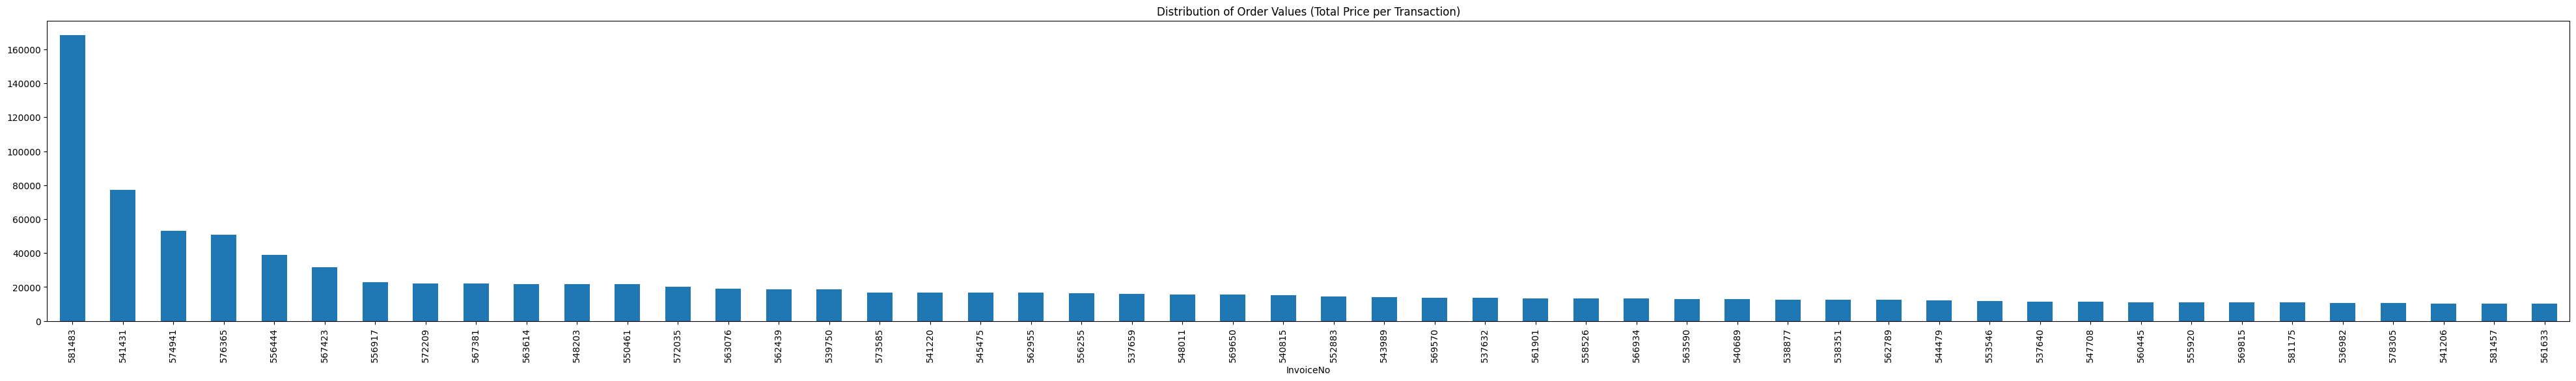

In [ ]:
data.groupby('InvoiceNo')['TotalPrice'].sum().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(50, 6))
plt.title('Distribution of Order Values (Total Price per Transaction)')

##### Are there seasonal patterns in purchasing behavior?

Text(0.5, 1.0, 'Total Sales by Season')

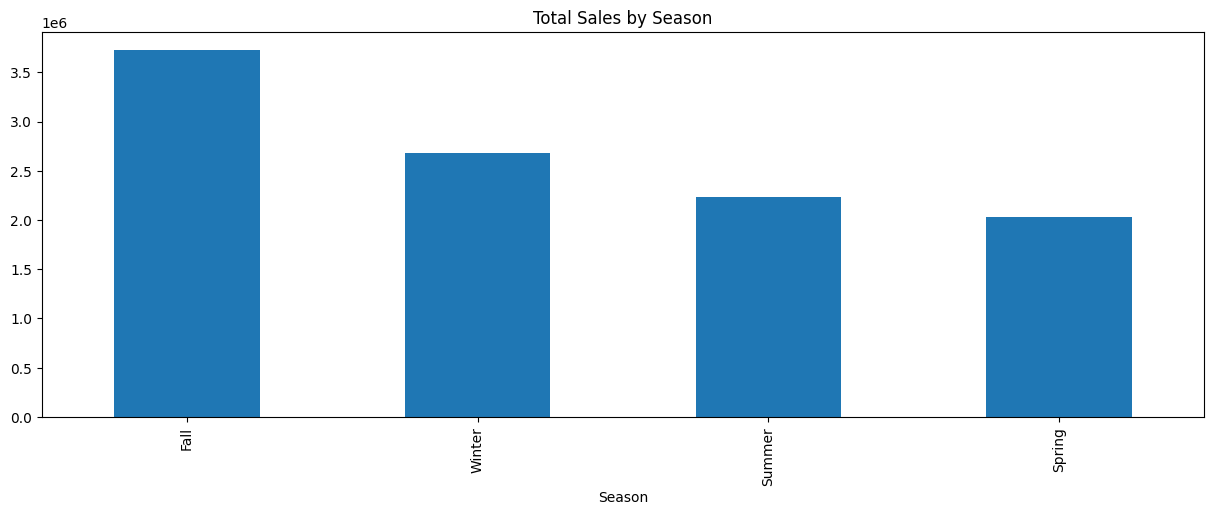

In [16]:
# first define seasons based on invoice date
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
# apply the function to create a new column
data['Season'] = pd.to_datetime(data['InvoiceDate']).apply(get_season)
# group by season and sum the total price
seasonal_sales = data.groupby('Season')['TotalPrice'].sum().sort_values(ascending=False)
seasonal_sales.plot(kind='bar', figsize=(15, 5))
plt.title('Total Sales by Season')

### 3. Product Analysis

##### What are the most frequently purchased products?

In [5]:
data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(20)

Description
PAPER CRAFT , LITTLE BIRDIE           80995
MEDIUM CERAMIC TOP STORAGE JAR        78033
WORLD WAR 2 GLIDERS ASSTD DESIGNS     55047
JUMBO BAG RED RETROSPOT               48474
WHITE HANGING HEART T-LIGHT HOLDER    37891
POPCORN HOLDER                        36761
ASSORTED COLOUR BIRD ORNAMENT         36461
PACK OF 72 RETROSPOT CAKE CASES       36419
RABBIT NIGHT LIGHT                    30788
MINI PAINT SET VINTAGE                26633
PACK OF 12 LONDON TISSUES             26135
PACK OF 60 PINK PAISLEY CAKE CASES    24854
VICTORIAN GLASS HANGING T-LIGHT       24304
ASSORTED COLOURS SILK FAN             23826
BROCADE RING PURSE                    23056
RED  HARMONICA IN BOX                 21933
JUMBO BAG PINK POLKADOT               21465
SMALL POPCORN HOLDER                  20160
PAPER CHAIN KIT 50'S CHRISTMAS        19355
LUNCH BAG RED RETROSPOT               19353
Name: Quantity, dtype: int64

##### What are the highest revenue-generating products?

<Axes: xlabel='Description'>

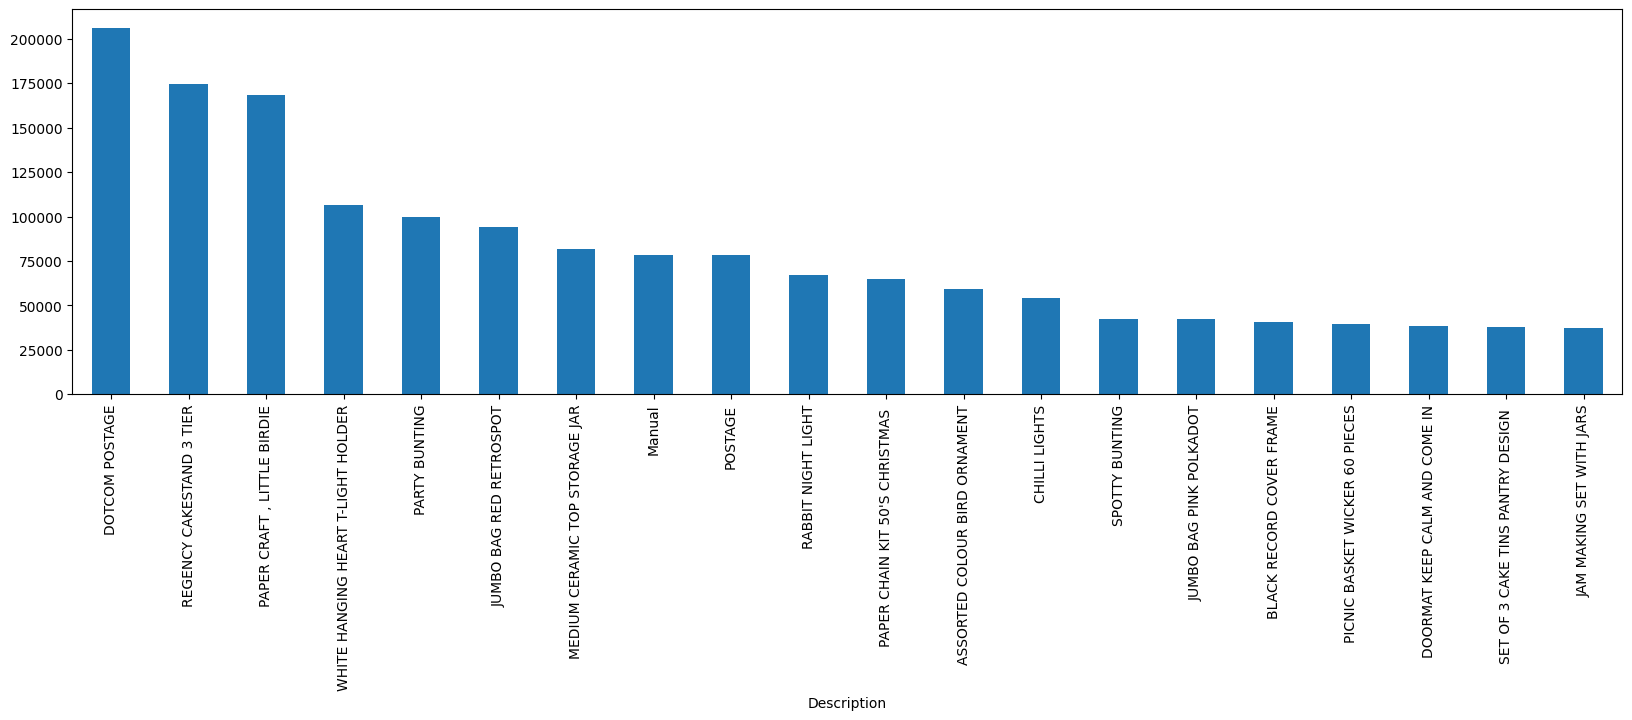

In [ ]:
data.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(20).plot(kind='bar', figsize=(20, 5))

##### How diverse is the product catalog and how are sales distributed across it?

<Axes: xlabel='Description'>

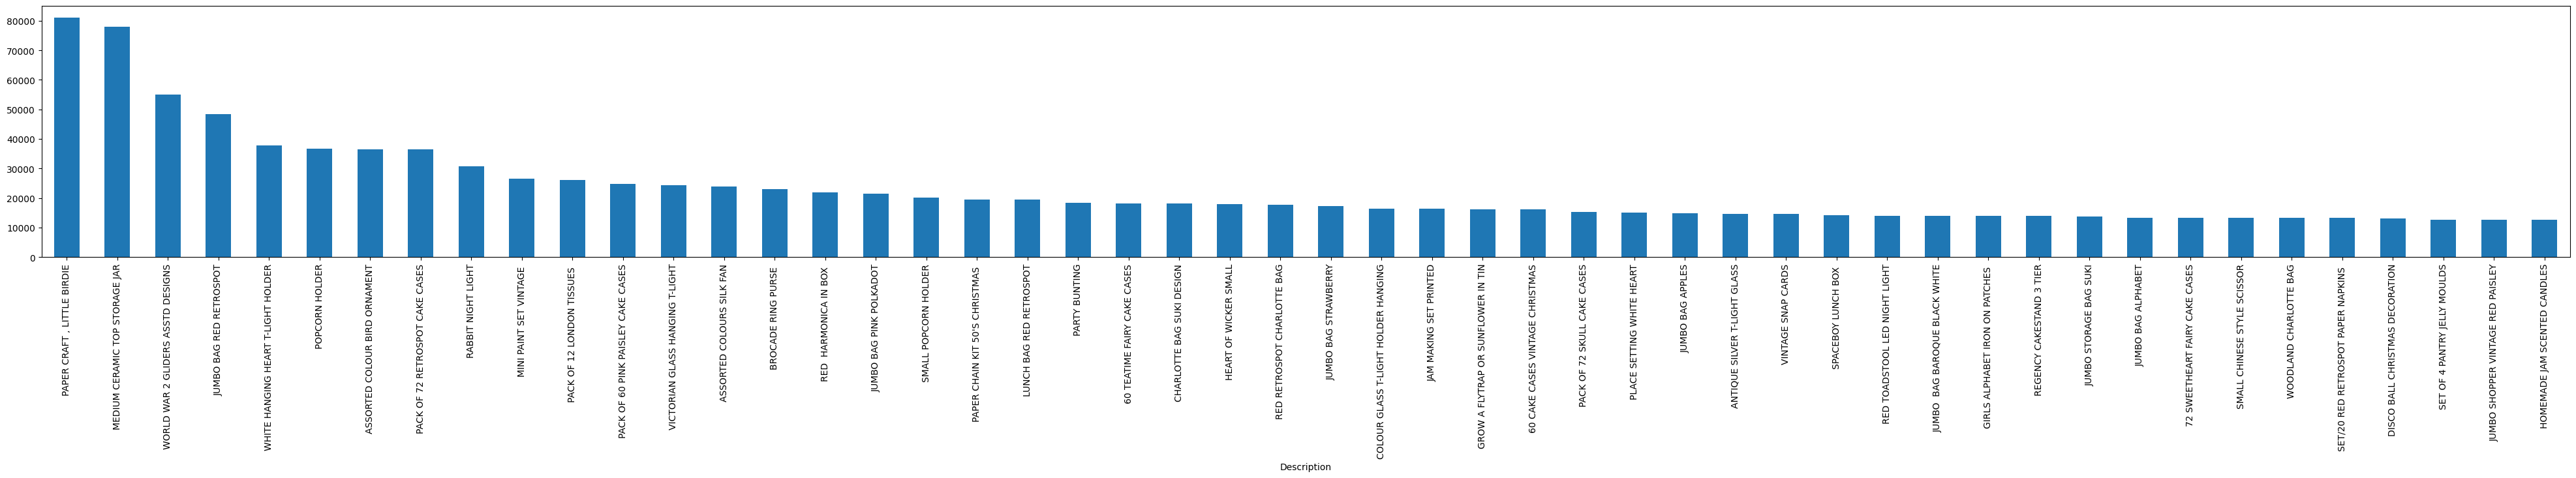

In [9]:
data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(50).plot(kind = 'bar', figsize=(50, 5))

##### Are there product categories or natural groupings that emerge?

In [17]:
# can't answer this right now.

### 4. Transaction Patterns

##### What is the distribution of transaction times/days?

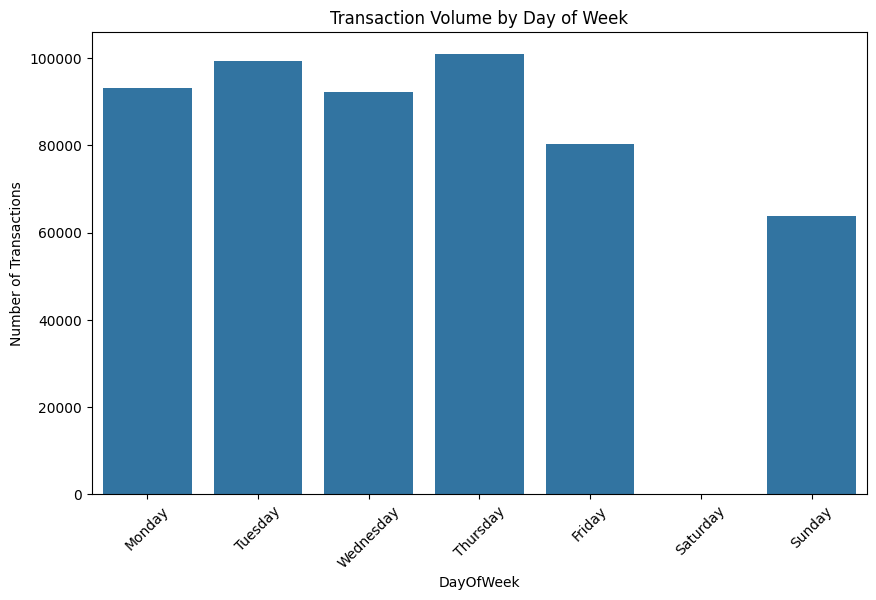

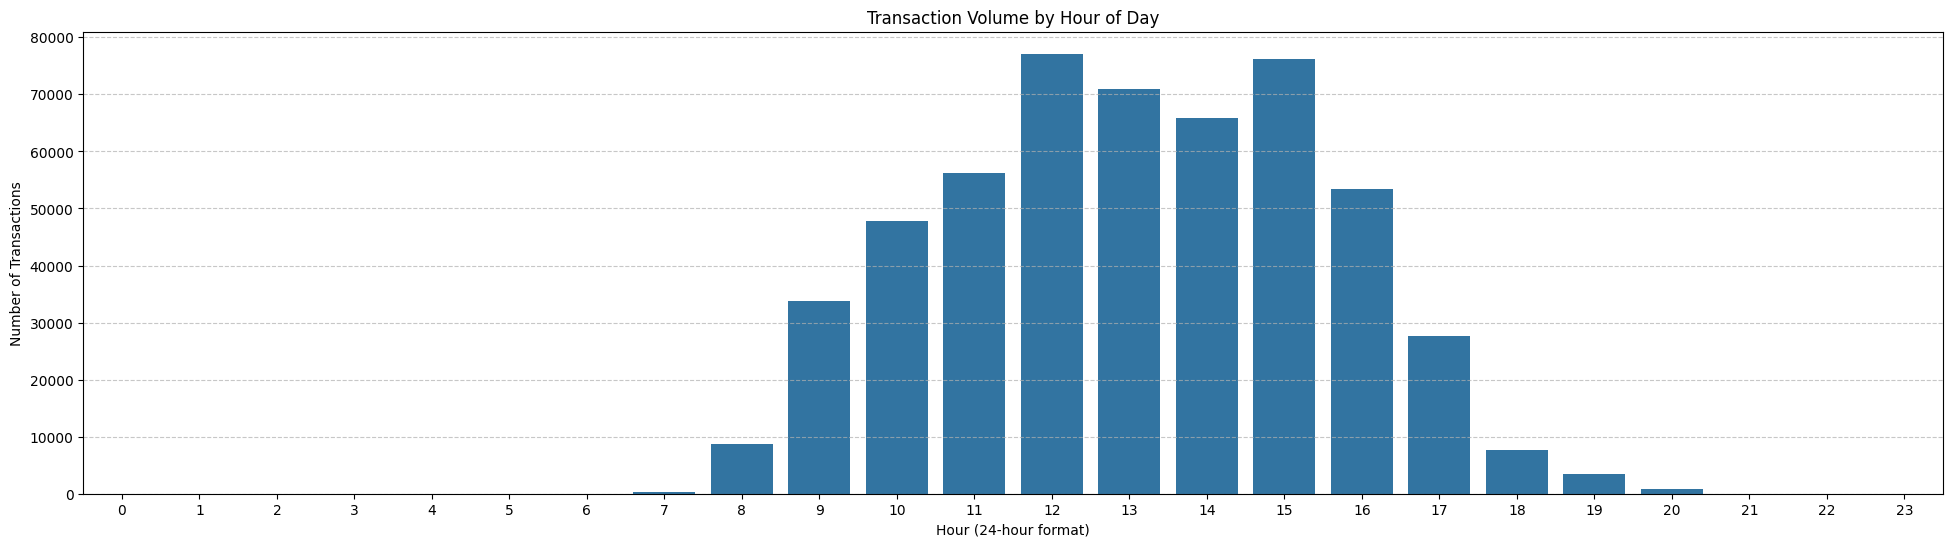

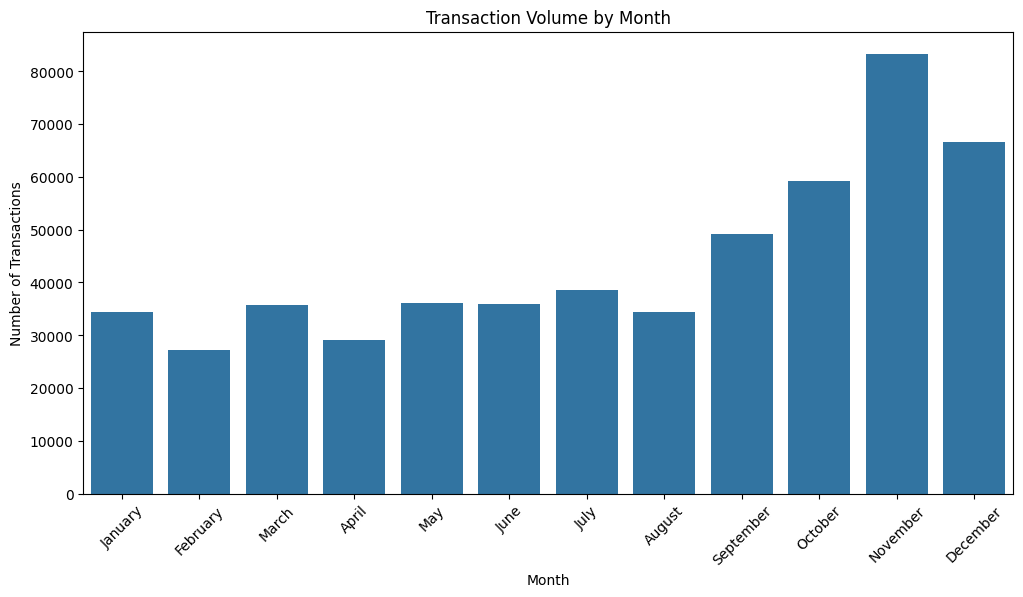

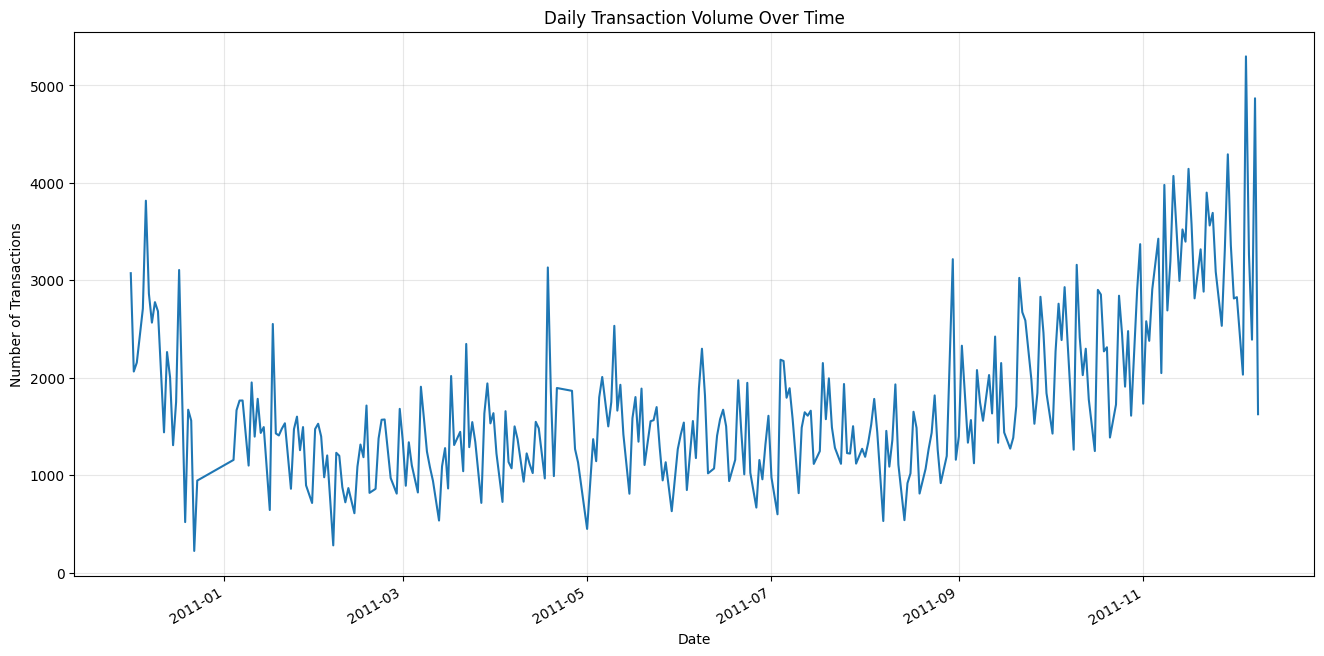

In [4]:
# find --> Day of the week, Time of the day, monthly patterns, visualization
data['Date'] = pd.to_datetime(data['InvoiceDate'].apply(lambda x: str(x).split(' ')[0].replace('/','-')))
data['Time'] = data['InvoiceDate'].apply(lambda x: str(x).split(' ')[1])
data['Hour'] = data['Time'].apply(lambda x: int(x.split(':')[0]))
data['DayOfWeek'] = data['Date'].dt.day_name()
data['Month'] = data['Date'].dt.month_name()

# 1. Day of Week Distribution
plt.figure(figsize=(10, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = data['DayOfWeek'].value_counts().reindex(day_order)
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Transaction Volume by Day of Week')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# 2. Hour of Day Distribution
plt.figure(figsize=(24, 6))
all_hours = pd.Series(range(24))
hour_counts = data['Hour'].value_counts().sort_index()
hour_counts = hour_counts.reindex(all_hours, fill_value=0)
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Transactions') 
plt.xticks(range(24))  # Explicitly mark all 24 hours
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 3. Monthly Distribution
plt.figure(figsize=(12, 6))
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_counts = data['Month'].value_counts().reindex(month_order)
sns.barplot(x=month_counts.index, y=month_counts.values)
plt.title('Transaction Volume by Month')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.show()

# 4. Calendar Heatmap (daily transactions)
daily_counts = data.groupby('Date').size()
plt.figure(figsize=(16, 8))
daily_counts.plot()
plt.title('Daily Transaction Volume Over Time')
plt.ylabel('Number of Transactions')
plt.grid(True, alpha=0.3)
plt.show()
# data

##### How do transaction patterns vary by country or customer segment?

###### For Country-based Analysis:

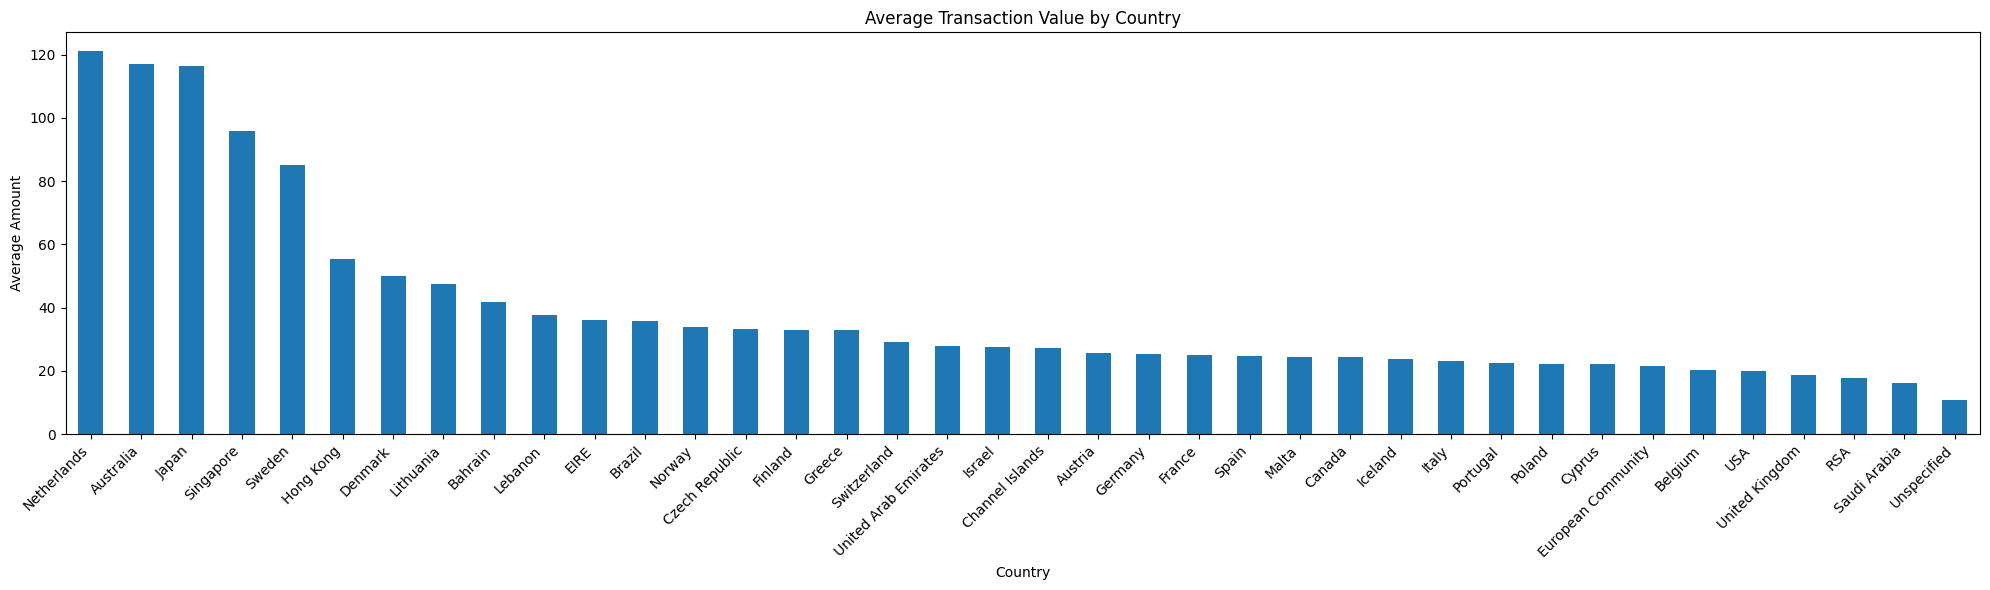

In [5]:
# Bar charts with grouped data:
country_avg = data.groupby('Country')['TotalPrice'].mean().sort_values(ascending=False)
country_avg.plot(kind='bar', figsize=(20, 6))
plt.title('Average Transaction Value by Country')
plt.ylabel('Average Amount')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Box plots for transaction value distribution:


##### Are there identifiable shopping peaks or patterns during the week/month?

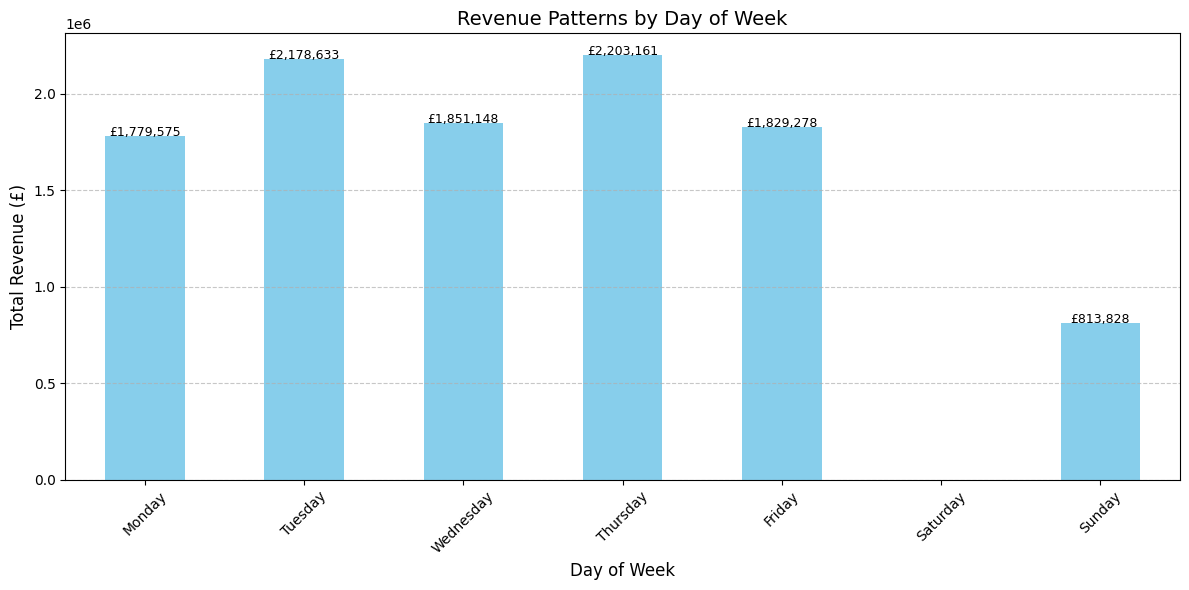


Revenue by Day of Week:
Monday: £1,779,575.04
Tuesday: £2,178,632.61
Wednesday: £1,851,147.81
Thursday: £2,203,161.24
Friday: £1,829,278.17
Saturday: £nan
Sunday: £813,827.61


In [6]:
# during week

# data['DayOfWeek'].unique().sum()
# day_counts = data['DayOfWeek'].value_counts().sort_values(ascending=False) # we can see that there are 6 days present in the dataset, excluding Saturday. maybe market is closed on Saturday.
# day_counts.plot(kind='bar', figsize=(10, 6))
# plt.xticks(rotation=45, ha='right')


# 1. **Revenue patterns by day of week** - This will show if certain days generate more sales, even if they don't have the most transactions
# Define the correct order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of week and sum total price
revenue_by_day = data.groupby('DayOfWeek')['TotalPrice'].sum().reindex(day_order)

# Create a visualization
plt.figure(figsize=(12, 6))
ax = revenue_by_day.plot(kind='bar', color='skyblue')
plt.title('Revenue Patterns by Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(revenue_by_day):
    ax.text(i, v + 0.1, f'£{v:,.0f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print the summary for additional insights
print("\nRevenue by Day of Week:")
for day, revenue in revenue_by_day.items():
    print(f"{day}: £{revenue:,.2f}")

# 2. **Average order value by day** - This indicates whether customers spend more per transaction on specific days



# 3. **Hourly patterns by day** - To identify peak shopping hours for each day of the week


In [7]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date,Time,Hour,DayOfWeek,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30,2010-12-01,8:26,8,Wednesday,December
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00,2010-12-01,8:26,8,Wednesday,December
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34,2010-12-01,8:26,8,Wednesday,December
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530099,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,10.20,2011-12-09,12:50,12,Friday,December
530100,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,12.60,2011-12-09,12:50,12,Friday,December
530101,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09,12:50,12,Friday,December
530102,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,16.60,2011-12-09,12:50,12,Friday,December
